In [12]:
# This is the notebook to run BCTT on sin-cos based simu-data

%matplotlib inline

import sys
sys.path.append('./..')
import numpy as np
import torch 
import matplotlib.pyplot as plt
from model_LDS_tucker_full_efficient import LDS_CEP_tucker_full_efficient
import os
import tqdm
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from matplotlib.ticker import NullFormatter
JITTER = 1e-4
import utils
torch.manual_seed(2)

In [3]:
# load data

data = np.load('../simu_data/simu_CP_multi_sincos_Tucker.npy', allow_pickle=True)
train_ind = data.item().get('train_ind')
train_y = data.item().get('train_y')
train_time = data.item().get('train_time_uni') # sorted & unique timestamps
train_time_ind = data.item().get('train_time_ind')


test_ind = data.item().get('test_ind')
test_y = data.item().get('test_y')
test_time = data.item().get('test_time_uni')
test_time_ind = data.item().get('test_time_ind')

ndims = data.item().get('ndims')

nmod = len(ndims)
N = train_y.size
N_time = train_time.size

R_U = 2
device = torch.device("cpu")

nepoch=100
gamma_size = np.prod([R_U for k in range(nmod)])

time_data_table = utils.build_time_data_table(train_time_ind)

U_true = data.item().get('U')

U = [3*torch.tensor(item).double()+torch.rand(item.shape) for item in U_true]

train_time = torch.tensor(train_time)
test_time = torch.tensor(test_time)

fix_int = None
time_int_list_follow = [train_time[i+1] - train_time[i] for i in range(N_time-1)]
time_int_list =torch.tensor([0.0] + time_int_list_follow)

train_y = torch.tensor(train_y).reshape(-1,1)
test_y = torch.tensor(test_y).reshape(-1,1)


# hyper-paras setting for LDS system
lengthscale = torch.tensor(0.1)
variance = torch.tensor(0.1)
noise = torch.tensor(0.1)

# matern kernel
lamb = np.sqrt(3)/lengthscale
F_base = torch.tensor([[0,1.0],
                [-lamb*lamb,-2*lamb]])
P_inf_base = torch.tensor([[variance,0.0],
                    [0,lamb*lamb*variance]])
H_base = torch.tensor([[1.0,0]])

F_list =[F_base for i in range(gamma_size)]
P_inf_list =[P_inf_base for i in range(gamma_size)]
H_list = [H_base for i in range(gamma_size)]

F = torch.block_diag(*F_list)
P_inf = torch.block_diag(*P_inf_list)
H = torch.block_diag(*H_list)


m_0 = torch.zeros(2*gamma_size,1)
P_0 = P_inf

# package the hypyerparas

hyper_para_dict = {}
hyper_para_dict['N'] = N
hyper_para_dict['F'] = F
hyper_para_dict['H'] = H
hyper_para_dict['R'] = noise
hyper_para_dict['P_inf'] = P_inf
hyper_para_dict['fix_int'] = fix_int # set as None if it's not fix 
hyper_para_dict['m_0'] = m_0
hyper_para_dict['P_0'] = P_0

hyper_para_dict['U'] = U
hyper_para_dict['device'] = device
hyper_para_dict['ind_tr'] = train_ind
hyper_para_dict['y_tr'] = train_y

hyper_para_dict['test_ind'] = test_ind
hyper_para_dict['test_y'] = test_y

hyper_para_dict['epoch'] = nepoch
hyper_para_dict['R_U'] = R_U
hyper_para_dict['v'] = 1
hyper_para_dict['a0'] = 10.0
hyper_para_dict['b0'] = 1.0
hyper_para_dict['time_int_list'] = time_int_list
hyper_para_dict['ndims'] = ndims
hyper_para_dict['train_time'] = train_time
hyper_para_dict['test_time'] = test_time

hyper_para_dict['train_time_ind'] = train_time_ind
hyper_para_dict['test_time_ind'] = test_time_ind
hyper_para_dict['N_time'] = N_time
hyper_para_dict['time_data_table'] = time_data_table
hyper_para_dict['gamma_size'] = gamma_size

hyper_para_dict['DAMPPING_U'] = 0.95
hyper_para_dict['DAMPPING_gamma'] = 0.8

In [5]:
model_class = LDS_CEP_tucker_full_efficient
model = model_class(hyper_para_dict)

expand_odrer = 'two'
# expand_odrer = 'one'


for i in tqdm.tqdm(range(40)):
    # for i in range(args.epoch):
    
    # LDS
    model.reset_list()
            
    # for k in tqdm.tqdm(range(model.N_time)):
    for k in range(model.N_time):

        model.msg_update_tau(time_id=k)
        model.filter_predict(ind=k)

        if expand_odrer == 'two':
            # two-order expand of conditional moment
            msg_gamma_m,msg_gamma_v = model.msg_update_gamma(time_id=k)
            model.filter_update_general(y= msg_gamma_m,R = msg_gamma_v )

        else:
            # one-order expand of conditional moment
            data_id = model.time_data_table[k]
            if len(data_id)>1:
                # more that one data-llk 
                R = torch.diag((model.msg_b[data_id]/model.msg_a[data_id]).squeeze())
                z = model.E_z[data_id].squeeze(-1).T
            else:
                data_id = data_id[0]
                R = model.msg_b[data_id]/model.msg_a[data_id]
                z = model.E_z[data_id]
            # print(z.shape)
            model.filter_update_simple(y= model.y_tr[data_id], R= R,z = z)

    model.smooth()
    del model.P_pred_list
    del model.P_list
    model.post_update_gamma()

    # tau
    model.post_update_tau()
    model.expectation_update_tau()
    # CEP 
    # U
    model.msg_update_U()
    model.post_update_U() 

    if i % 2 == 0:
        loss_test_rmse,loss_test_MAE = model.model_test(hyper_para_dict['test_ind'],hyper_para_dict['test_y'],hyper_para_dict['test_time'])
        print('loss_test_rmse: %.4f,loss_test_MAE: %.4f'%(loss_test_rmse,loss_test_MAE) )


  0%|          | 0/40 [00:00<?, ?it/s]C:\Users\Tianfan Wu\Anaconda3\envs\torch_gpu_110\lib\site-packages\tensorly\backend\pytorch_backend.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=requires_grad)
  2%|▎         | 1/40 [00:03<02:20,  3.59s/it]

loss_test_rmse: 1.2581,loss_test_MAE: 1.0584


  8%|▊         | 3/40 [00:10<02:10,  3.54s/it]

loss_test_rmse: 0.7645,loss_test_MAE: 0.6335


 12%|█▎        | 5/40 [00:17<02:02,  3.50s/it]

loss_test_rmse: 0.1862,loss_test_MAE: 0.1406


 18%|█▊        | 7/40 [00:24<01:54,  3.46s/it]

loss_test_rmse: 0.1223,loss_test_MAE: 0.0969


 22%|██▎       | 9/40 [00:31<01:46,  3.45s/it]

loss_test_rmse: 0.1021,loss_test_MAE: 0.0802


 28%|██▊       | 11/40 [00:38<01:40,  3.46s/it]

loss_test_rmse: 0.0929,loss_test_MAE: 0.0726


 32%|███▎      | 13/40 [00:45<01:33,  3.45s/it]

loss_test_rmse: 0.0876,loss_test_MAE: 0.0681


 38%|███▊      | 15/40 [00:52<01:26,  3.46s/it]

loss_test_rmse: 0.0839,loss_test_MAE: 0.0651


 42%|████▎     | 17/40 [00:59<01:19,  3.47s/it]

loss_test_rmse: 0.0815,loss_test_MAE: 0.0631


 48%|████▊     | 19/40 [01:05<01:12,  3.47s/it]

loss_test_rmse: 0.0798,loss_test_MAE: 0.0617


 50%|█████     | 20/40 [01:12<01:12,  3.64s/it]


KeyboardInterrupt: 

In [4]:
# gamma = model.post_gamma_m.squeeze().cpu().numpy()
# np.save('simu_post_W', gamma)

learnt_gamma = np.load('simu_post_W.npy')


In [8]:
gamma.shape

(3000, 4)

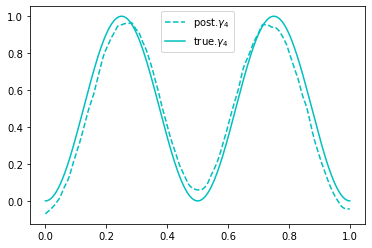

In [11]:

lam = lambda t:(\
    np.sin(t*2*np.pi),\
    np.cos(t*2*np.pi), \
    np.sin(t*2*np.pi)*np.cos(t*2*np.pi)*np.sin(t*2*np.pi),\
    np.sin(t*2*np.pi)*np.sin(t*2*np.pi)
    )
gamma_true = lam(train_time)

# we normalized the post_gamma_m by the maximum posterior mean of the corresponding state.(computed manully)
#  This is to address the identifiablility issue, see details at footnote of paper

plt.plot(train_time.numpy(),model.post_gamma_m.squeeze().cpu().numpy()[:,3]/1.4,'c--',label=r"post.${\gamma_4}$")
plt.plot(train_time.numpy(),gamma_true[3].squeeze().cpu().numpy(),'c',label=r"true.${\gamma_4}$")

plt.legend()

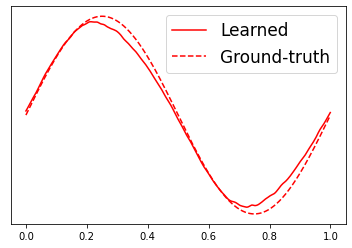

In [33]:
plt.plot(train_time.numpy(),gamma[:,0]/0.75,'r',label=r"Learned")
plt.plot(train_time.numpy(),gamma_true[0].squeeze().cpu().numpy(),'r--',label=r"Ground-truth")

ax = plt.gca()
ax.axes.get_yaxis().set_visible(False)
plt.legend(prop={'size': 17})

plt.savefig('dynamic_1.pdf')

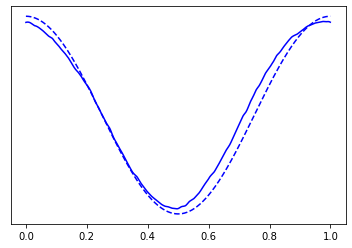

In [25]:
plt.plot(train_time.numpy(),gamma[:,2]/0.5,'b',label=r"post.${\gamma_2}$")
plt.plot(train_time.numpy(),gamma_true[1].squeeze().cpu().numpy(),'b--',label=r"true.${\gamma_2}$")
ax = plt.gca()
ax.axes.get_yaxis().set_visible(False)
plt.savefig('dynamic_2.pdf')

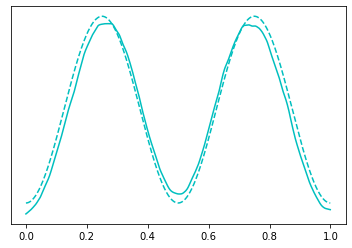

In [26]:
plt.plot(train_time.numpy(),gamma[:,3]/0.8,'c',label=r"post.${\gamma_3}$")
plt.plot(train_time.numpy(),gamma_true[3].squeeze().cpu().numpy(),'c--',label=r"true.${\gamma_3}$")
ax = plt.gca()
ax.axes.get_yaxis().set_visible(False)
# plt.legend()
plt.savefig('dynamic_3.pdf')

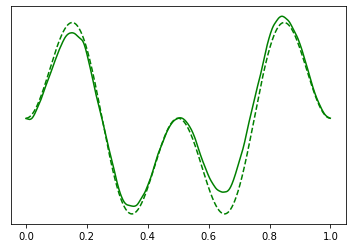

In [82]:
plt.plot(train_time.numpy(),gamma[:,1]/1.2,'g',label=r"post.${\gamma_4}$")
plt.plot(train_time.numpy(),gamma_true[2].squeeze().cpu().numpy(),'g--',label=r"true.${\gamma_4}$")
# plt.legend()
ax = plt.gca()
ax.axes.get_yaxis().set_visible(False)
plt.savefig('dynamic_4.pdf')


In [39]:
leant_U = [item.cpu().numpy() for item in  model.post_U_m]

np.save('simu_post_U',leant_U)

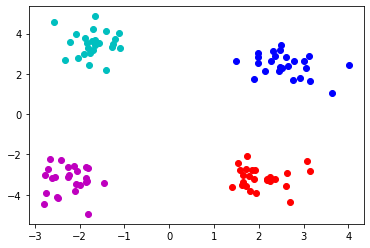

In [59]:
U0 = model.post_U_m[0].squeeze().numpy()
U1 = model.post_U_m[1].squeeze().numpy()

half_size = 25
plt.scatter(U0[:half_size,0]*2,U0[:half_size,1]*4,c='r')
plt.scatter(U0[half_size:,0]*2,U0[half_size:,1]*4,c='b')


plt.scatter(U1[:half_size:,0]*2.5,U1[:half_size,1]*3,c='c')
plt.scatter(U1[half_size:,0]*2.5,U1[half_size:,1]*3,c='m')

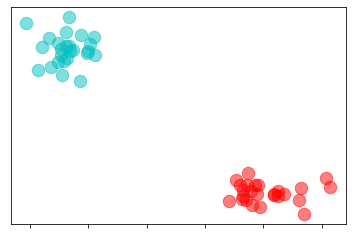

In [75]:
from matplotlib.ticker import NullFormatter
plt.scatter(U1[:half_size:,0],U1[:half_size,1],c='c',s=155,alpha=0.5)
plt.scatter(U0[:half_size,0],U0[:half_size,1],c='r',s=155,alpha=0.5)


ax = plt.gca()
ax.axes.get_yaxis().set_visible(False)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.savefig('cluster_mode1.pdf')

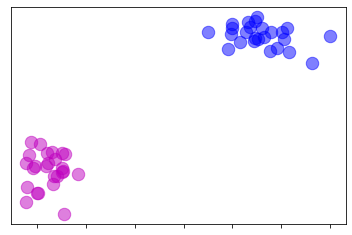

In [78]:
from matplotlib.ticker import NullFormatter
plt.scatter(U0[half_size:,0],U0[half_size:,1],c='b',s=155,alpha=0.5)
plt.scatter(U1[half_size:,0],U1[half_size:,1],c='m',s=155,alpha=0.5)


ax = plt.gca()
ax.axes.get_yaxis().set_visible(False)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.savefig('cluster_mode2.pdf')